# Notebook 55: Tidal spin-down

In [1]:
from pathlib import Path
from math import isnan, nan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import linregress

import astropy.constants as ct
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo

import mesa_reader as mr
import mesaPlot as mp
#import tulips as tp

import sys
sys.path.append('..')
from src.util import CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT
from src.star import fix_unit
from src.binary import WindIntegrator

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
MASS_U = u.M_sun
PERIOD_U = u.day
AGE_U = u.yr
SMA_U = u.R_sun
RADIUS_U = u.R_sun
TEMP_U = u.K
LUMINOSITY_U = u.Lsun
OMEGA_U = 1 / u.s
TORQUE_U = u.g * u.cm**2 / u.s**2
DENSITY_U = u.g / u.cm**3

UOQ_TYPE = float | u.quantity.Quantity
"""Type union of float and astropy.units.quantity.Quantity."""

t_H = cosmo.age(0).to(AGE_U).value

In [3]:
Z_SUN = 0.017

In [4]:
def p_from_a(a, m, q):
    a = fix_unit(a, SMA_U)
    m = fix_unit(m, MASS_U)
    p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
    p = p.to(PERIOD_U)
    return p

def a_from_p(p, m, q):
    p = fix_unit(p, PERIOD_U)
    m = fix_unit(m, MASS_U)
    a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
    a = a.to(SMA_U)
    return a

In [5]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
    
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [6]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

In [7]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [8]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

# Orbital widening

In [9]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m * a
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e3:.2f} kyr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q, t1

In [10]:
def radiative_damping_torque(total_m, total_r, core_m, core_r, core_bound_rho, p_spin, p_orb, q=1, beta2=1.):
    total_m = fix_unit(total_m, MASS_U)
    total_r = fix_unit(total_r, RADIUS_U)
    core_m = fix_unit(core_m, MASS_U)
    core_r = fix_unit(core_r, RADIUS_U)
    core_bound_rho = fix_unit(core_bound_rho, DENSITY_U)
    p_spin = fix_unit(p_spin, PERIOD_U)
    p_orb = fix_unit(p_orb, PERIOD_U)
    
    w_spin = 2*np.pi/p_spin
    w_orb = 2*np.pi/p_orb
    a = a_from_p(p_orb, total_m, 1)
    d = 2*a
    sc = 2 * np.abs(w_spin - w_orb) * np.sqrt(core_r**3 / ct.G / core_m)
    
    mean_rho_b = (core_m / (4/3 * np.pi * core_r**3)).to(DENSITY_U)
    rho_ratio = core_bound_rho / mean_rho_b
    mass_term = ct.G * (q*total_m)**2 / core_r
    
    torque = beta2 * mass_term * (core_r/d)**6 * sc**(8/3) * rho_ratio * (1 - rho_ratio)**2
    sign = np.sign(w_orb - w_spin)
    return sign * torque.to(TORQUE_U)
    

In [11]:
def get_moment_of_inertia(prof, stop_i=-1):
    r_arr = prof.radius[::-1] * u.Rsun.to(u.cm)
    rho_arr = 10.**prof.logRho[::-1]
    
    r_arr = r_arr[:stop_i]
    rho_arr = rho_arr[:stop_i]
    
    i = 0
    for rho, r0, r1 in zip(rho_arr, r_arr[:-1], r_arr[1:]):
        dv = 4/3 * np.pi * (r1**3 - r0**3)
        di = rho * r0**2 * dv
        i += di
        
    return i

In [12]:
path = model_dicts_01zsun['80.0']['1.40']
logs = mr.MesaLogDir(str(path/'LOGS'))

In [13]:
logs.model_numbers

array([   1,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3731])

In [14]:
sync_tscale_evolution = np.zeros((len(logs.model_numbers), 8))
# age center_h1 center_he4 center_c12 p_orb p_spin torque tscale

for i, n in enumerate(logs.model_numbers):
    prof = logs.profile_data(model_number=n)
    conv_core_bound_i = len(prof.mixing_type) - np.where(prof.mixing_type[::-1] != 1)[0][0]
    conv_core_bound_i = min(conv_core_bound_i, len(prof.mixing_type)-1)
    conv_core_bound_rho = 10.**prof.logRho[conv_core_bound_i] * u.g * u.cm**-3
    conv_core_m = prof.mass[conv_core_bound_i] * u.Msun
    conv_core_r = prof.radius[conv_core_bound_i] * u.Rsun
    total_m = prof.mass[0] * u.Msun
    total_r = prof.radius[0] * u.Rsun
    w_spin = prof.omega[0] / u.s
    p_spin = 2*np.pi / w_spin
    total_moment_of_inertia = get_moment_of_inertia(prof) * u.g * u.cm**2

    wi = WindIntegrator(path)
    _m, p_orb, *_ = wi.integrate(prof.star_age)
    p_orb *= u.d.to(u.s) * u.s

    torque = radiative_damping_torque(total_m, total_r, conv_core_m, conv_core_r, conv_core_bound_rho, p_spin, p_orb)

    sync_timescale = np.abs(1/(torque/total_moment_of_inertia / w_spin)).to(u.yr).value
    
    sync_tscale_evolution[i] = [
        prof.star_age,
        prof.h1[-1],
        prof.he4[-1],
        prof.c12[-1],
        p_orb.value,
        p_spin.value,
        torque.value,
        sync_timescale
    ]
        

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0, 0.5, '$P_\\mathrm{spin}/\\mathrm{d}$')

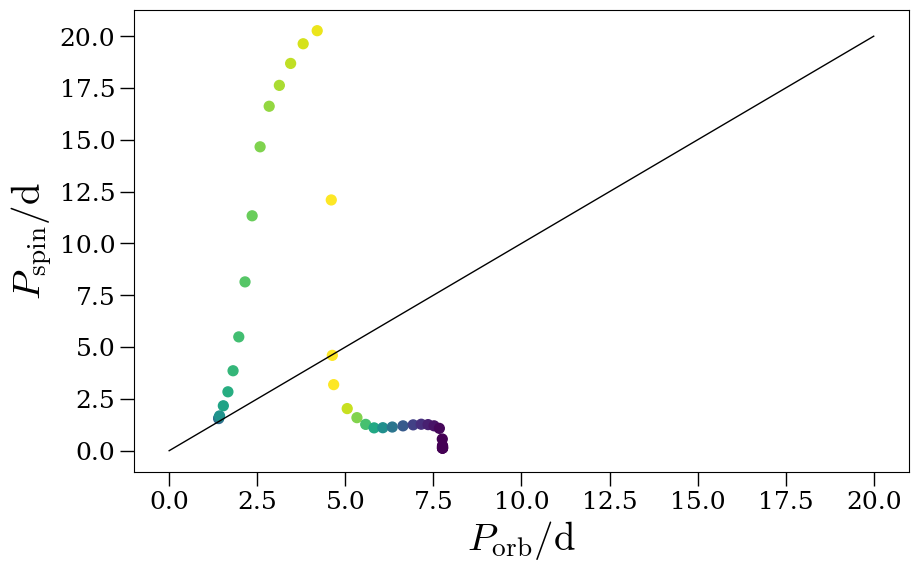

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = cm.viridis

x = sync_tscale_evolution[:, 4] / u.d.to(u.s)
y = sync_tscale_evolution[:, 5] / u.d.to(u.s)
c = sync_tscale_evolution[:, 2]

ax.scatter(x, y, c=c, cmap=cmap, s=50)
ax.plot(np.linspace(0, 20, 10), np.linspace(0, 20, 10), 'k-', lw=1)
#ax.set_xlim(0, 20)
ax.set_xlabel('$P_\\mathrm{orb}/\\mathrm{d}$')
ax.set_ylabel('$P_\\mathrm{spin}/\\mathrm{d}$')
#ax.set_ylim(0, 20)
#ax.set_yscale('log')
#ax.set_ylim(1e-3, 1e6)

(0.001, 1000000000000.0)

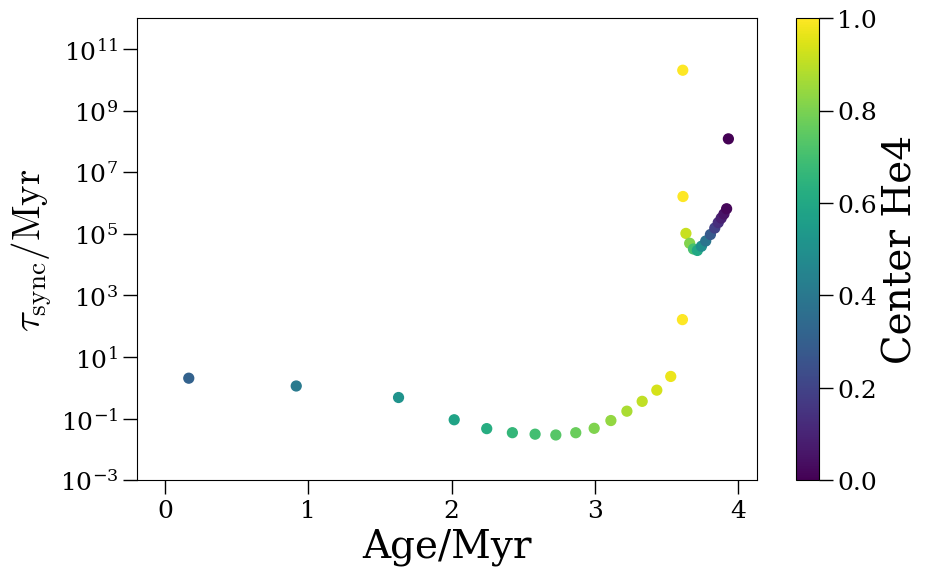

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = cm.viridis

x = sync_tscale_evolution[:, 0] / 1e6
y = sync_tscale_evolution[:, 7] / 1e6
c = sync_tscale_evolution[:, 2]

ax.scatter(x, y, c=c, cmap=cmap, s=50)
ax.set_yscale('log')
#ax.set_ylim(1e-3, 1e6)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\tau_\mathrm{sync}/\\mathrm{Myr}$')

sm = cm.ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('Center He4')
ax.set_ylim(1e-3, 1e12)

In [18]:
p_orb, p_spin

(<Quantity 18142677.8390437 s>, <Quantity 127012.57781125 s>)

In [19]:
total_moment_of_inertia * w_spin

<Quantity 2.94732148e+50 cm2 g / s>

In [20]:
torque = radiative_damping_torque(total_m, total_r, conv_core_m, conv_core_r, conv_core_bound_rho, p_spin, p_orb)

In [21]:
torque

<Quantity -1.84579961e-12 cm2 g / s2>

In [22]:
np.abs(1/(torque/total_moment_of_inertia / w_spin)).to(u.Myr)

<Quantity 5.05986573e+48 Myr>

In [23]:
prof.omega

array([4.94690008e-05, 4.94690008e-05, 4.94691358e-05, ...,
       3.85730004e-03, 3.85730004e-03, 3.85730004e-03])

In [24]:
prof.mixing_type

array([1, 1, 1, ..., 7, 7, 7])